In [1]:
import pandas as pd
import numpy as np
import re
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

from sklearn.metrics import f1_score

from transformers import BertTokenizer, BertModel
from transformers import AutoModel, AutoTokenizer 

In [2]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [4]:
# Normal dataset
df = pd.read_csv('smallDomainDataBertweetEmbedded.csv')

# Epsilon 0,1 fair dataset
#df = pd.read_csv("domain_data_with_identities_private_xtrain0,1.csv")

# Epsilon 0,01 fair dataset
#df = pd.read_csv("domain_data_with_identities_private_xtrain0,1.csv")

df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

(768,)

In [7]:
# Updating values for training_data
training_data = df[df['split'] == 'train']
#training_data = training_data.drop(training_data.query('toxicity==0').sample(frac=.85).index)

# Getting test_data
test_data = df[df['split'] == 'test']

# Getting validation_data
validation_data = df[df['split'] == 'val']
#validation_data = validation_data.drop(validation_data.query('toxicity==0').sample(frac=.85).index)

In [8]:
print('Toxic samples training data: ', sum(training_data['toxicity']))
print('None-toxic samples training data: ', len(training_data['toxicity'])-sum(training_data['toxicity']))

print("\n")
print('Toxic samples validation data: ', sum(validation_data['toxicity']))
print('None-toxic samples validation data: ', len(validation_data['toxicity'])-sum(validation_data['toxicity']))

print("\n")
print('Toxic samples test data: ', sum(test_data['toxicity']))
print('None-toxic samples test data: ', len(test_data['toxicity'])-sum(test_data['toxicity']))

print("\n")

for col in training_data.columns[3:]:
    print(col + ": " + str(np.sum(training_data[col])))

Toxic samples training data:  710
None-toxic samples training data:  710


Toxic samples validation data:  360
None-toxic samples validation data:  360


Toxic samples test data:  360
None-toxic samples test data:  360


male: 322.0
female: 276.0
LGBTQ: 234.0
christian: 214.0
muslim: 236.0
other_religion: 20.0
black: 250.0
white: 370.0


In [12]:
# Creating data loaders
X_train = np.array(training_data['comment_text'].values.tolist())
Y_train = np.array(training_data['toxicity'].values.tolist())

X_test = np.array(test_data['comment_text'].values.tolist())
Y_test = np.array(test_data['toxicity'].values.tolist())

X_val = np.array(validation_data['comment_text'].values.tolist())
Y_val = np.array(validation_data['toxicity'].values.tolist())

prepare_trainloader = []
for i in range(len(X_train)):
    prepare_trainloader.append([X_train[i], Y_train[i]])
    
prepare_testloader = []
for i in range(len(X_test)):
    prepare_testloader.append([X_test[i], Y_test[i]])
    
prepare_validloader = []
for i in range(len(X_val)):
    prepare_validloader.append([X_val[i], Y_val[i]])

train_loader = torch.utils.data.DataLoader(prepare_trainloader, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(prepare_validloader, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(prepare_testloader, batch_size=batch_size, shuffle=False)

In [45]:
### Set parameters for the model
#torch.manual_seed(42) # set fixed random seed for reproducibility
batch_size = 16
epochs = 1000
lr = 0.00001

cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [47]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)

In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(768, 64), nn.ReLU(), nn.Dropout(p=0.8))
        self.fc2 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        #self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [49]:
# Setting up model parameters
model = Net().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_function = nn.BCELoss()
#loss_function = nn.MSELoss()
#loss_function = nn.NLLLoss()

# Initialising early stopping criterias
early_stopping = 50
notImproved = 0
bestLoss = None
bestModel = None

trainArr = []
valArr = []

bestf1 = 0
bestEpoch = 0

for epoch in range(1, epochs + 1):
    
    train_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        
        # get the input
        inputs, labels = data
    
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        
        outputs = model(inputs)
        outputs = outputs.squeeze(1)
        
        loss = loss_function(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader.dataset)
    
    
    trainArr.append(train_loss)
    
    valid_loss = 0
    labs = []
    preds = []
    
    model.eval()
    with torch.no_grad():        
        for batch_idx, data in enumerate(valid_loader):
            # get the input
            inputs, labels = data
            
            inputs = inputs.to(device).float()
            #labels = labels.to(device).long()
            labels = labels.to(device).float()
            
            outputs = model(inputs).squeeze()
            
            labs.extend(labels)
            preds.extend(torch.round(outputs))
            #preds.extend(outputs.argmax(axis=1))
            
            valid_loss += loss_function(outputs, labels).item()
    
    valid_loss /= len(valid_loader.dataset)
    
    valArr.append(valid_loss)
    
    
    
    #if epoch % 10 == 0:
        #print('====> Validation set loss: {:.6f}'.format(valid_loss))
    
        #print("Accuracy on Validation set: ", CheckAccuracy(labs, preds))
    
    #f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
    #print("F1_score: ", f1)
    
    #if f1 > bestf1:
    #    bestModel = model
    #    bestf1 = f1
    #    notImproved = 0
    #    bestEpoch = epoch
    
    if bestLoss == None:
        bestLoss = valid_loss
    
    
    if valid_loss <= bestLoss:
        bestModel = model
        bestLoss = valid_loss
        notImproved = 0
        bestEpoch = epoch
    
    else:
        notImproved +=1
        
    if notImproved >= early_stopping:
        break
        
    
    # Initialising params for early stopping
    #if bestLoss == None:
    #    bestLoss = valid_loss
        
    # Checks for early stopping
    #if f1 < bestf1:
    #    bestLoss = valid_loss
        
    # Converges if the training has not improved for a certain amount of iterations
    

model = bestModel

print(bestEpoch)

#torch.save(model, 'bestModelFullyConnectedNetwork0,1Fair.pth')

233


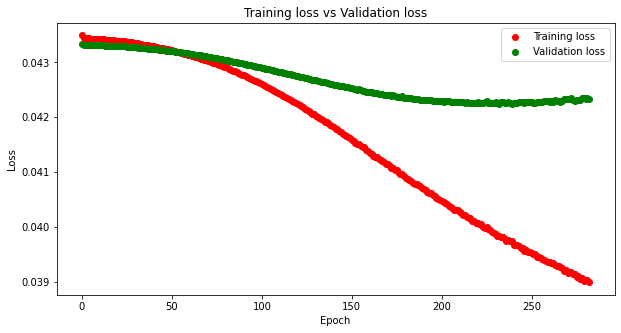

In [53]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(0,len(trainArr)), trainArr, color='r', label='Training loss')
plt.scatter(np.arange(0,len(valArr)), valArr, color='g', label='Validation loss')
plt.title("Training loss vs Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [54]:
def F1_Scores(preds, labels):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i in range(len(labs)):
        if labels[i]==1 and preds[i]==1:
            true_positives += 1
        if labels[i]==0 and preds[i]==0:
            true_negatives += 1
        if labels[i]==0 and preds[i]==1:
            false_positives += 1
        if labels[i]==1 and preds[i]==0:
            false_negatives += 1
    print("true_positives", true_positives)
    print("true_negatives", true_negatives)
    print("false_positives", false_positives)
    print("false_negatives", false_negatives)
    
    return true_positives, true_negatives, false_positives, false_negatives

In [57]:
labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(test_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on test set: ", CheckAccuracy(labs, preds))

f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
print("F1_score: ", f1)


model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(valid_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on validation set: ", CheckAccuracy(labs, preds))

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(train_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on train set: ", CheckAccuracy(labs, preds))



true_positives, true_negatives, false_positives, false_negatives = F1_Scores(preds, labs)

#print("Toxic accuracy: ", true_positives/5640)
#print("Non-toxic accuracy: ", true_negatives/42235)

Accuracy on test set:  0.6083333333333333
F1_score:  0.607242339832869
Accuracy on validation set:  0.5972222222222222
Accuracy on train set:  0.6272727272727273
true_positives 904
true_negatives 890
false_positives 540
false_negatives 526


In [56]:
from diffprivlib.models import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

epsilons = [0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 40, 50, 60, 70, 80, 90, 1000]



for eps in epsilons:
    print(eps)
    clf = LogisticRegression(epsilon=eps)
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    f1 = f1_score(predictions, Y_test, zero_division=1)
    
    print("F1_score: ", f1)
    
    print(clf.score(X_test, Y_test))
    print("\n")
    
    #F1_Scores(predictions, Y_test)

#predictions = np.array(predictions).reshape(len(predictions), 1)
#Y_test = np.array(Y_test).reshape(len(Y_test), 1)

0.0001
F1_score:  0.6660465116279071
0.5013888888888889


0.001
F1_score:  0.011049723756906079
0.5027777777777778


0.01
F1_score:  0.0
0.5


0.1
F1_score:  0.1268292682926829
0.5027777777777778


1
F1_score:  0.47692307692307695
0.5277777777777778


10
F1_score:  0.4914586070959264
0.4625


30


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLea

F1_score:  0.545945945945946
0.5333333333333333


40
F1_score:  0.5702364394993046
0.5708333333333333


50
F1_score:  0.5563093622795116
0.5458333333333333


60


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no addi

F1_score:  0.5729877216916781
0.5652777777777778


70
F1_score:  0.5950413223140496
0.5916666666666667


80
F1_score:  0.5778401122019634
0.5819444444444445


90


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no addi

F1_score:  0.5685425685425686
0.5847222222222223


1000
F1_score:  0.5977961432506887
0.5944444444444444




C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
